## XgBoost to correct ETT flaws in speed profiles
In this notebook I am exploring Xgboost as a corrective algorithm for speed profile estimates in Jakarta.The features are listed below.
* 'expected_time' --> the expected time of travel by summing up the mean travel times of all road segments.
* 'median_time'--> the median time of travel by summing up the median travel times of all road segments.
* 'worst_case_time' --> worst case travel time.
* 'best_case_time' --> best case travel time.
* 'day_of_week' --> The day of week Mon 0 to Sun 6.
* 'hour_sin' --> Sine/cosine transform of hour of day
* 'hour_cos' --> Sine/cosine transform of hour of day
* 'ape_edt' --> absolute percentage error between Abhinav's EDT and route engine EDT (this is a temporary feature.)
* label --> Actual travel time.

In [17]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print(xgb.__file__)

/usr/local/lib/python3.6/dist-packages/xgboost-0.72-py3.6.egg/xgboost/__init__.py


### Read the data for City


In [2]:
#some constants for the notebook
city_id=4
filter_bad_edt=False
edt_mape_tolerance=0.4

## Read train  data



In [3]:
train_data_raw=pd.read_csv(f"ETT/CITY_{city_id}_train.csv")
train_data_speed_profile=pd.read_csv(f"ETT/ETT_CITY_{city_id}_train_speed_profile.csv")
train_data=pd.merge(train_data_raw, train_data_speed_profile, on='booking_id', how='inner')
#only those rides with distance and time greater than 100 meters and 10 seconds respectively.
train_data=train_data[train_data['ATT']>10]
train_data=train_data[train_data['driver_distance']>0.1]
train_data.head()



,booking_id,awarded_time,driver_lat,driver_lon,pickup_lat,pickup_lon,driver_distance,ATT,edt_local,expected_time,median_time,worst_case_time,best_case_time
0,ADR-4022412-3-221,2018-05-02T13:58:53.229Z,14.646231,121.060127,14.646227,121.034195,5.820,1020,6227.813133,699.498523,713.499953,703.888338,695.256202
1,ADR-7439772-3-850,2018-04-02T06:34:22.844Z,14.551877,121.016930,14.616375,121.053619,10.408,1739,10936.991592,2315.437013,2592.553279,2318.309985,2312.600601
2,ADR-12980574-3-361,2018-04-16T05:57:25.168Z,14.603065,120.974060,14.604239,121.002823,4.141,1732,4255.815520,1041.531259,1158.555502,1045.985964,1037.162828
3,IOS-5805995-3-1042,2018-04-15T12:25:50.541Z,14.569815,121.015701,14.537567,121.003830,7.396,1216,6526.359500,869.478667,875.867671,873.024975,866.050309
4,IOS-12633188-3-1343,2018-04-21T00:14:29.954Z,14.560925,121.097496,14.553447,121.054718,6.616,1341,7976.410570,1151.502467,1146.741099,1160.853819,1142.519843


## Read test data

In [4]:
test_data_raw=pd.read_csv("ETT/CITY_{city_id}_test.csv".format(city_id=city_id))
test_data_speed_profile=pd.read_csv("ETT/ETT_CITY_{city_id}_test_speed_profile.csv".format(city_id=city_id))
test_data=pd.merge(test_data_raw, test_data_speed_profile, on='booking_id', how='inner')
test_data=test_data[test_data['ATT']>10]
test_data=test_data[test_data['driver_distance']>0.1]
test_data.head()

,booking_id,awarded_time,driver_lat,driver_lon,pickup_lat,pickup_lon,driver_distance,ATT,edt_local,expected_time,median_time,worst_case_time,best_case_time
0,ADR-97558001-3-002,2018-05-28T09:47:18.224Z,14.645843,120.986885,14.612526,120.996994,5.377,1195,5595.206156,1010.809019,1065.479021,1014.838556,1006.864323
1,ADR-2985489-3-291,2018-05-25T15:54:10.445Z,14.561709,121.027466,14.482243,121.036926,12.218,1094,11773.816444,1021.603159,1017.894447,1026.097173,1017.230049
2,IOS-30006009-3-1002,2018-05-27T12:25:04.693Z,14.577582,121.059433,14.551324,121.023399,6.479,1085,6411.737501,816.962137,853.031075,819.293723,814.686936
3,ADR-92057027-3-021,2018-05-26T10:47:11.309Z,14.478283,120.991646,14.573576,120.982552,12.279,2129,12307.100634,1533.140758,1550.984685,1537.317505,1529.159939
4,IOS-1974524-3-914,2018-05-30T12:22:13.759Z,14.651339,121.074615,14.666794,121.042862,6.107,1044,6205.383433,826.071062,888.551298,829.604676,822.637531


In [5]:
test_data = test_data.rename(columns={'ATT': 'label'})
train_data = train_data.rename(columns={'ATT': 'label'})

### Evaluating speed profiles
For evaluating speed profiles in the conference paper. Delete cell and below afterwards

In [ ]:
eval_speed_profiles=test_data[['awarded_time','driver_distance','expected_time','median_time',\
                               'worst_case_time','best_case_time','label']]
eval_speed_profiles["awarded_time"]=pd.to_datetime(eval_speed_profiles["awarded_time"])
eval_speed_profiles["awarded_time"] = eval_speed_profiles["awarded_time"].dt.tz_localize('UTC').dt.tz_convert('Asia/Singapore')
eval_speed_profiles["minute_of_day"]=eval_speed_profiles["awarded_time"].dt.hour*60+eval_speed_profiles["awarded_time"].dt.minute
#Monday is 0 and Sunday is 6.
eval_speed_profiles["day_of_week"]=eval_speed_profiles["awarded_time"].dt.weekday
eval_speed_profiles["hour_of_day"]=eval_speed_profiles["awarded_time"].dt.hour

eval_speed_profiles=eval_speed_profiles[['minute_of_day','driver_distance','expected_time','median_time',\
                               'worst_case_time','best_case_time','label']]

eval_speed_profiles.to_csv(f'speed_profiles_{city_id}.csv',index=False)

### Transform train test for xgboost model.

In [6]:
def modify_train_test_data(data):
    
    def print_metrics():
        ape_ett=np.abs(data["label"]-data["expected_time"])/data["label"]
        ape_ett=ape_ett[ape_ett< np.percentile(ape_ett,99)]
        print("MAPE ETT",ape_ett.mean())

        sq_error_ett = (data["label"]-data["expected_time"]) ** 2
        sq_error_ett=sq_error_ett[sq_error_ett< np.percentile(sq_error_ett,99)]
        print("Square error ETT",np.sqrt(sq_error_ett.mean()))

        abs_error_ett = abs(data["label"]-data["expected_time"])
        abs_error_ett=abs_error_ett[abs_error_ett< np.percentile(abs_error_ett,99)]
        print("Absolute error ETT",abs_error_ett.mean())

        #bias
        ett_bias=data["label"]-data["expected_time"]
        ett_bias=ett_bias[ett_bias< np.percentile(ett_bias,99)]
        print("Bias ETT",ett_bias.mean())
        
          
    
    data['driver_distance'] =data['driver_distance']*1000.0
    data['mape_edt']=np.abs(data['driver_distance']-data['edt_local'])/data['driver_distance']
    print("MAPE EDT",data['mape_edt'].mean())
    if filter_bad_edt:
        data=data[data['mape_edt']<edt_mape_tolerance]

    print("Shape of data ", data.shape)
    print_metrics()
    data["awarded_time"]=pd.to_datetime(data["awarded_time"])
    data["awarded_time"] = data["awarded_time"].dt.tz_localize('UTC').dt.tz_convert('Asia/Singapore')
    data["minute_of_day"]=data["awarded_time"].dt.hour*60+data["awarded_time"].dt.minute
    #Monday is 0 and Sunday is 6.
    data["day_of_week"]=data["awarded_time"].dt.weekday
    data["hour_of_day"]=data["awarded_time"].dt.hour

    #transform hour to cyclical feature, I don't think day of week is cyclical though
    data['time_sin'] = np.sin(data.minute_of_day*2*np.pi/1440)
    data['time_cos'] = np.cos(data.minute_of_day*2*np.pi/1440)
    train_test = data[['label','minute_of_day','driver_distance','expected_time','median_time','worst_case_time','best_case_time','day_of_week']]
    #log transform of the label
    train_test['label']=np.log(train_test.label)
    train_test.loc[:,'expected_time']=(train_test.expected_time-np.mean(train_test.expected_time))/np.std(train_test.expected_time)
    train_test.loc[:,'median_time']=(train_test.median_time-np.mean(train_test.median_time))/np.std(train_test.median_time)
    train_test.loc[:,'worst_case_time']=(train_test.worst_case_time-np.mean(train_test.worst_case_time))/np.std(train_test.worst_case_time)
    train_test.loc[:,'best_case_time']=(train_test.best_case_time-np.mean(train_test.best_case_time))/np.std(train_test.best_case_time)
    train_test.loc[:,'driver_distance']=(train_test.driver_distance-np.mean(train_test.driver_distance))/np.std(train_test.driver_distance)
    train_test.loc[:,'minute_of_day']=(train_test.minute_of_day-np.mean(train_test.minute_of_day))/np.std(train_test.minute_of_day)
    X=train_test.iloc[:,1:]
    y=train_test.iloc[:,0]
    return X,y
    


### Transform training and test data

In [7]:
X_train,y_train=modify_train_test_data(train_data)
X_train.head()

MAPE EDT 0.13249782377808292
Shape of data  (1400055, 14)
MAPE ETT 0.2760827084813461
Square error ETT 536.1794872124785
Absolute error ETT 393.88238232999134
Bias ETT 349.02462343441795


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,minute_of_day,driver_distance,expected_time,median_time,worst_case_time,best_case_time,day_of_week
0,1.423031,-0.143877,-0.537490,-0.567018,-0.537988,-0.537081,2
1,0.199203,0.852306,2.150057,2.398905,2.134557,2.164793,0
2,0.097218,-0.508435,0.031361,0.135463,0.028327,0.034095,0
3,1.166689,0.198317,-0.254788,-0.310735,-0.257996,-0.251759,6
4,-0.848217,0.028957,0.214260,0.116815,0.218481,0.210100,5


In [8]:
X_test,y_test=modify_train_test_data(test_data)
X_test.head()

MAPE EDT 0.13118731700769296
Shape of data  (466670, 14)
MAPE ETT 0.26937535615224206
Square error ETT 528.376739991547
Absolute error ETT 388.5987446054824
Bias ETT 350.5381086140508


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,minute_of_day,driver_distance,expected_time,median_time,worst_case_time,best_case_time,day_of_week
0,0.728762,-0.273010,-0.058083,-0.048522,-0.061513,-0.054933,0
1,1.741336,1.161069,-0.040720,-0.121245,-0.043487,-0.038184,4
2,1.164693,-0.041997,-0.369902,-0.373203,-0.374604,-0.365441,6
3,0.894306,1.173856,0.782132,0.693469,0.775039,0.788961,5
4,1.156416,-0.119980,-0.355250,-0.318918,-0.358095,-0.352595,2


### Data transformation

In [9]:
train,test,train_label,test_label = np.array(X_train,dtype=np.float64),\
np.array(X_test,dtype=np.float64),np.array(y_train,dtype=np.float64),np.array(y_test,dtype=np.float64)
#print(xgb.__file__)

In [10]:
regressor = xgb.XGBRegressor(max_depth=8, n_estimators=1000,tree_method='gpu_hist',eval_metric='rmse')
regressor.fit(train,train_label)
output = regressor.predict(test)

In [11]:
def metrics(y_true,y_pred):
    ape_ett=np.abs(y_true-y_pred)/y_true
    ape_ett=ape_ett[ape_ett< np.percentile(ape_ett,99)]
    print("MAPE ETT",ape_ett.mean())

    sq_error_ett = (y_true-y_pred) ** 2
    sq_error_ett=sq_error_ett[sq_error_ett< np.percentile(sq_error_ett,99)]
    print("Square error ETT",np.sqrt(sq_error_ett.mean()))

    abs_error_ett = abs(y_true-y_pred)
    abs_error_ett=abs_error_ett[abs_error_ett< np.percentile(abs_error_ett,99)]
    print("Absolute error ETT",abs_error_ett.mean())

    #bias
    ett_bias=y_true-y_pred
    ett_bias=ett_bias[ett_bias< np.percentile(ett_bias,99)]
    print("Bias ETT",ett_bias.mean())

In [12]:
metrics(np.exp(test_label),np.exp(output))

MAPE ETT 0.19367768078129005
Square error ETT 338.3356278853561
Absolute error ETT 247.53363458795823
Bias ETT 50.38566901017514


### Plot relative feature importances

In [13]:
sorted_idx = np.argsort(regressor.feature_importances_)[::-1]
feature_importance={}
for index in sorted_idx:
    feature_importance[X_train.columns[index]]= regressor.feature_importances_[index]

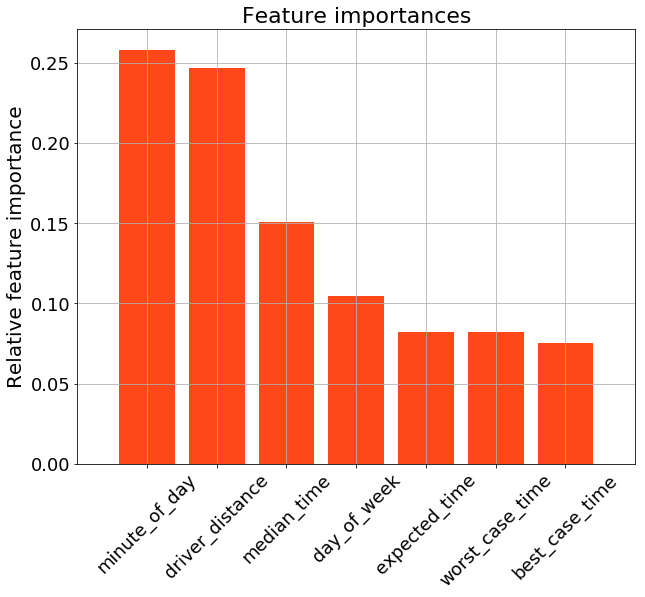

In [14]:
n_features=7
ss = sorted(feature_importance, key=feature_importance.get, reverse=True)
top_names = ss[0:]
f=plt.figure(figsize=(10,8))
plt.grid(True)
plt.title("Feature importances",fontsize=22)
plt.bar(range(n_features), [feature_importance[i] for i in top_names], color="#ff471a", align="center")
plt.xlim(-1, n_features)
plt.ylabel('Relative feature importance',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(range(n_features), top_names, rotation=45,fontsize=18)
f.savefig("feauture_importance.pdf", bbox_inches='tight')

### Store results for future use

In [15]:
test_data['predicted']=pd.Series(np.exp(output))
test_data['label']=pd.Series(np.exp(test_label))
test_data.head()

,booking_id,awarded_time,driver_lat,driver_lon,pickup_lat,pickup_lon,driver_distance,label,edt_local,expected_time,median_time,worst_case_time,best_case_time,mape_edt,minute_of_day,day_of_week,hour_of_day,time_sin,time_cos,predicted
0,ADR-97558001-3-002,2018-05-28 17:47:18.224000+08:00,14.645843,120.986885,14.612526,120.996994,5377.0,1195.0,5595.206156,1010.809019,1065.479021,1014.838556,1006.864323,0.040581,1067,0,17,-0.998392,-0.056693,1319.966797
1,ADR-2985489-3-291,2018-05-25 23:54:10.445000+08:00,14.561709,121.027466,14.482243,121.036926,12218.0,1094.0,11773.816444,1021.603159,1017.894447,1026.097173,1017.230049,0.036355,1434,4,23,-0.026177,0.999657,1292.625977
2,IOS-30006009-3-1002,2018-05-27 20:25:04.693000+08:00,14.577582,121.059433,14.551324,121.023399,6479.0,1085.0,6411.737501,816.962137,853.031075,819.293723,814.686936,0.010382,1225,6,20,-0.806445,0.591310,1132.222290
3,ADR-92057027-3-021,2018-05-26 18:47:11.309000+08:00,14.478283,120.991646,14.573576,120.982552,12279.0,2129.0,12307.100634,1533.140758,1550.984685,1537.317505,1529.159939,0.002289,1127,5,18,-0.979045,0.203642,2084.424561
4,IOS-1974524-3-914,2018-05-30 20:22:13.759000+08:00,14.651339,121.074615,14.666794,121.042862,6107.0,1044.0,6205.383433,826.071062,888.551298,829.604676,822.637531,0.016110,1222,2,20,-0.814116,0.580703,1142.468994


In [16]:
result=test_data[['label','predicted','driver_distance','minute_of_day']]
result.dropna(inplace=True)
result.to_csv(f'results_{city_id}.csv',index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
